In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')

from tqdm import tqdm
import csv
import datetime
import warnings

import numpy as np
from scipy.integrate import IntegrationWarning

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
from aatw.snr import *
from aatw.spectral import *
from aatw.nfw import rho_NFW
from aatw.graveyard import sample_snr_stz_G, sample_t_pk, sample_Snu1GHz_pk, sample_size_1kyr, sample_size_now
from aatw.geometry import Glbd

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## 1. Download

In [ ]:
! wget "http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR" -O ../data/snr/SNRcat-SNR.csv
! wget "http://snrcat.physics.umanitoba.ca/SNRdownload.php?table=SNR" -O ../data/snr/SNRcat-OBS.csv

In [ ]:
# removed first 2 lines of the files
date_str = datetime.date.today().strftime("%Y%m%d")
for tag in ['SNR', 'OBS']:
    reader = csv.reader(open(f'../data/snr/SNRcat-{tag}.csv', 'r'), delimiter=';')
    next(reader); next(reader)
    writer = csv.writer(open(f'../data/snr/SNRcat{date_str}-{tag}_dehead.csv', 'w'), delimiter=';')
    writer.writerows(reader)

## 2. Filter valid SNR

### 2.1 Valid SNR from SNRcat

In [3]:
date_str = '20230426'

In [4]:
snr_list = []

with open(f'../data/snr/SNRcat{date_str}-SNR_dehead.csv', 'r') as csvf:
    csv_reader = csv.DictReader(csvf, delimiter=';')
    
    for i, row in enumerate(csv_reader):
        
        if row['G'] == 'G358.1+00.1':
            row['G'] = 'G358.1+01.0' # error in SNRcat
            
        snr = SNR(
            ID = row['G'],
            name_alt = row['id_alt'],
            snr_type = row['type'],
            l = float(row['G'][1:6]) * deg,
            b = float(row['G'][6:11]) * deg,
            size = float(row['size_coarse (arcmin)']) * arcmin,
            snrcat_dict = row
        )
        
        d_min = row['distance_min (kpc)'] # must have dist min & max
        d_max = row['distance_max (kpc)']
        t_now_min = row['age_min (yr)'] # must have age min & max
        t_now_max = row['age_max (yr)']
        
        snr.d_min = float(d_min) if d_min != '' else None
        snr.d_max = float(d_max) if d_max != '' else None
        snr.t_now_min = float(t_now_min) if t_now_min != '' else None
        snr.t_now_max = float(t_now_max) if t_now_max != '' else None
        
        if snr.d_min is not None:
            if snr.d_max is not None:
                snr.d = np.sqrt(snr.d_min * snr.d_max)
            else:
                snr.d = snr.d_min
        else:
            if snr.d_max is not None:
                snr.d = snr.d_max
            else:
                snr.d = None
            
        if snr.t_now_min is not None:
            if snr.t_now_max is not None:
                snr.t_now = np.sqrt(snr.t_now_min * snr.t_now_max)
            else:
                snr.t_now = snr.t_now_min
        else:
            if snr.t_now_max is not None:
                snr.t_now = snr.t_now_max
            else:
                snr.t_now = None
        
        snr_list.append(snr)
        if not np.any(np.array([snr.d_min, snr.d_max, snr.t_now_min, snr.t_now_max]) == None):
            print('|', end='', flush=True)
        else:
            print('.', end='', flush=True)
print(f'  (| means full d and t_now information.)')

|..|..|..............|...||.|...........|............||...|.....|..||.....|.|..|..|....|.||..|...|....|.|.||...|||.|...|.|.|.|||||..|.....|||...|..|..|||..|.|.||||..|..|...||.||||.||..||......|..|.||..|.|.|||....||..|.||..||...|....|.|||..||.||..|.....||.|.|...|...|......|....|..|....|....|...||.|....|....||.|...|...|||..|.||..........|....|||.|...|.......||...|..|....|......|.|..  (| means full d and t_now information.)


In [5]:
l = ''
for snr in snr_list:
    s = ''
    s += 'O' if snr.d_min is not None else '-'
    s += 'O' if snr.d_max is not None else '-'
    s += 'O' if snr.t_now_min is not None else '-'
    s += 'O' if snr.t_now_max is not None else '-'
    l += s + ' '
    if len(l) >= 120:
        print(l)
        l = ''

OOOO ---- OO-O OOOO OO-- ---- OOOO ---- OO-- ---- OO-- ---- ---- OO-- OO-- OO-- ---- ---- OO-- ---- ---- OOOO OO-- ---- 
---- OOOO OOOO OO-- OOOO ---- OO-- OO-- ---- OO-- ---- ---- OO-- ---- ---- ---- OOOO ---- ---- ---- OO-- ---- ---- O-OO 
OO-- OO-- ---- ---- OO-- OOOO OOOO OO-- ---- ---- OOOO ---- ---- ---- ---- OO-- OOOO ---- OO-- OOOO OOOO ---- OO-- OO-- 
---- ---- OOOO ---- OOOO ---- OO-- OOOO ---- OO-- OOOO OO-- OO-- ---- OO-- OOOO OO-- OOOO OOOO OO-- OO-O OOOO ---- ---- 
---- OOOO OO-- OO-- OO-- ---- OOOO OO-- OOOO ---- OOOO OOOO ---- ---- ---- OOOO OOOO OOOO OO-- OOOO OO-- OO-- O--- OOOO 
O--- OOOO OO-- OOOO ---- OOOO OOOO OOOO OOOO OOOO OO-- ---- OOOO ---- OO-- ---- OOO- OO-- OOOO OOOO OOOO OO-- OO-- OO-- 
OOOO ---- ---- OOOO ---- -O-- OOOO OOOO OOOO O--- OO-- OOOO ---- OOOO ---- OOOO OOOO OOOO OOOO O-OO OO-- OOOO OO-- OOO- 
OOOO OO-- ---- ---- OOOO OOOO OO-- OOOO OOOO OOOO OOOO OO-- OOOO OOOO ---- OO-O OOOO OOOO ---- ---- OOO- ---- ---- OO-- 
OOOO ---- ---- OOOO ---- OOOO OO

### 2.2 Valid SNR from Green's catalog
Requires SNR to have flux information. Copy [this page](https://www.mrao.cam.ac.uk/surveys/snrs/snrs.data.html) to `../data/SNR/Green.txt`

In [6]:
for snr in snr_list:
    print(('.' if snr.Snu1GHz is None else '|'), end='')

...............................................................................................................................................................................................................................................................................................................................................................................................

In [7]:
varied_str = ''
cant_find_str = ''

with open('../data/snr/Green.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[4:]):
        line_strs = list(filter(None,line.split(' ')))
        green_dict = {}
        green_dict['ID'] = GID(line_strs[0], line_strs[1])
        green_dict['name_oth'] = '' if len(line_strs)<=11 else ' '.join(line_strs[11:]).replace('\n', '')
        green_dict['size_str'] = line_strs[7]
        green_dict['type'] = line_strs[8]
        green_dict['Snu1GHz'] = line_strs[9]
        green_dict['spec_ind'] = line_strs[10].replace('\n', '')
        
        snr = get_snr(green_dict['ID'], snr_list)
        snr.green_dict = green_dict
        
        Snu1GHz_str = green_dict['Snu1GHz'].replace('?','').replace('>','')
        if Snu1GHz_str != '':
            snr.Snu1GHz = float(Snu1GHz_str)
        
        si_str = green_dict['spec_ind'].replace('?','')
        if si_str != '':
            try:
                snr.si = float(si_str)
            except ValueError:
                snr.si = si_str
                varied_str += '\n'+green_dict['ID']+' '+green_dict['spec_ind']+' '+green_dict['name_oth']
        
    if cant_find_str == '':
        cant_find_str = 'None.'
    print('can\'t find: '+cant_find_str)
    print(varied_str)

can't find: None.

G000.9+00.1 varies 
G006.4-00.1 varies W28
G021.5-00.9 varies 
G027.8+00.6 varies 
G031.9+00.0 varies 3C391
G033.2-00.6 varies 
G065.7+01.2 varies DA 495
G069.0+02.7 varies CTB 80
G074.0-08.5 varies Cygnus Loop
G074.9+01.2 varies CTB 87
G180.0-01.7 varies S147
G263.9-03.3 varies Vela (XYZ)
G326.3-01.8 varies MSH 15-56
G354.1+00.1 varies 


In [8]:
for snr in snr_list:
    print(('.' if snr.Snu1GHz is None else '|'), end='')

|.|||||||||||||.||||.||||.|||||||||.||||||||||||.||||||||||||||.|.|||||.|.|||.||..|||..|||..|||||||.|.|||.||.||.|||||||||.||.||||||||.|.|||||...|.|||.|||.||.|||..||||||.|..||||||||||.||......||..|.|.|||.|||..|...|||.||||..|.|..|.|.||.|||||||.|||||.|||.|||||||.|..|.|||...|||||.||.|..||.|..|....||||||||||..|||.|..|.|..||||.||||||||||.||.|..|.|||||..||||..||||||...|||||||||||.|.|||..

### 2.3 Individual changes

In [9]:
snr = get_snr('G263.9-03.3', snr_list)
snr.name_alt = 'Vela'
snr.si = (2.47-1)/2 # fiducial: 2.47
snr.t_now = 12000 # fiducial: 10000-12000-14000
snr.d = 0.287 # kpc
snr.Snu1GHz = 670

snr = get_snr('G006.4-00.1', snr_list)
snr.name_alt = 'W28'
snr.si = 0.42 # Kassim 1992 | 330 MHz VLA OBSERVATIONS OF 20 GALACTIC SUPERNOVA REMNANTS
# density # https://arxiv.org/pdf/1805.03372.pdf, Reach et al 2005
snr.t_now = 34467 # yr
snr.d = 1.876 # kpc

snr = get_snr('G039.7-02.0', snr_list)
snr.name_alt = 'W50'
snr.t_now = 54772 # fiducial: 30000-54772-100000
snr.d = 4.77 # kpc
snr.si = 0.7 # fiducial: 0.7

snr = get_snr('G326.3-01.8', snr_list)
snr.name_alt = 'MSH 15-56'
snr.si = 0.34 # RADIO EMISSION FROM THE COMPOSITE SUPERNOVA REMNANT G326.3-1.8 (MSH 15-56)

In [10]:
dump_snr_list(snr_list, "../outputs/snr/prebuild_snr_list.json")

## 3. Full info list and partial info list

In [ ]:
snr_list = load_snr_list("../outputs/snr/prebuild_snr_list.json")

In [11]:
snr_list_fullinfo = []
snr_list_partialinfo = []

for snr in snr_list:
    v = np.array([snr.d_min, snr.d_max, snr.t_now_min, snr.t_now_max, snr.Snu1GHz, snr.si])
    if np.all(v != None):
        snr_list_fullinfo.append(snr)
    else:
        snr_list_partialinfo.append(snr)

dump_snr_list(snr_list_fullinfo, "../outputs/snr/prebuild_snr_list_fullinfo.json")
dump_snr_list(snr_list_partialinfo, "../outputs/snr/prebuild_snr_list_partialinfo.json")
print(f'Full info {len(snr_list_fullinfo)}/{len(snr_list)}.')

Full info 102/383.


### 3.1 Build fullinfo list

In [12]:
for snr in tqdm(snr_list_fullinfo):
    if isinstance(snr.si, str):
        snr.si = 0.5
    snr.t_MFA = 100 # [yr]
    snr.t_free = 300 # [yr]
    snr.build(rho_DM=rho_NFW, tiop='2')
    
dump_snr_list(snr_list_fullinfo, f"../outputs/snr/snr-fullinfo-nolightcurve.json")

100%|█████████████████████████████████████████████████████████████████████████████████| 102/102 [00:06<00:00, 16.54it/s]


In [13]:
for snr in tqdm(snr_list_fullinfo):
    snr.t_pk = 50/365.25 # [yr] | use mean value for now
    snr.build(rho_DM=rho_NFW, tiop='2', use_lightcurve=True, infer_lightcurve_from_now=True)
dump_snr_list(snr_list_fullinfo, f"../outputs/snr/snr-fullinfo-lightcurve.json")

100%|█████████████████████████████████████████████████████████████████████████████████| 102/102 [00:09<00:00, 11.09it/s]


### 3.2 Sample and build partialinfo list

In [14]:
for i_sample in tqdm(range(100)):
    
    snr_list_partialinfo = load_snr_list("../outputs/snr/prebuild_snr_list_partialinfo.json")
    for snr in snr_list_partialinfo:

        if snr.d is None:
            snr.d = Glbd(sample_snr_stz_G(1))[0, 2].item() # [kpc]

        if snr.t_now is None:
            snr.t_now = np.random.uniform(1e3, 1e5)

        if snr.size == 0:
            snr.size = sample_size_now(1, t_now=snr.t_now).item()

        if snr.si is None or isinstance(snr.si, str):
            snr.si = 0.5

        # Snu1GHz
        snr.t_free = 300.
        if snr.Snu1GHz is not None:
            infer_lightcurve_from_now = True
            snr.t_pk = sample_t_pk(1).item()
        else:
            infer_lightcurve_from_now = False
            snr.Snu1GHz_pk = sample_Snu1GHz_pk(1, d=snr.d, si=snr.si).item()
            snr.t_pk = sample_t_pk(1).item()

        snr.build(integrate_method='trapz',
                  use_lightcurve=True, infer_lightcurve_from_now=infer_lightcurve_from_now)
    dump_snr_list(snr_list_partialinfo, f"../outputs/snr/partialinfo_samples/partialinfo_{i_sample}.json")

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


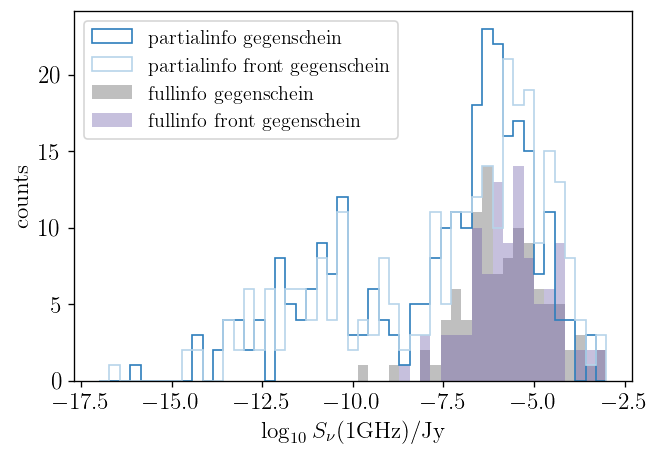

In [3]:
snr_list_fullinfo = load_snr_list("../outputs/snr/snr-fullinfo-lightcurve.json")
snr_list_partialinfo = load_snr_list("../outputs/snr/partialinfo_samples/partialinfo_0.json")

fig, ax = plt.subplots()

bins = np.linspace(-17, -3, 50)

ax.hist(np.log10([snr.Sgnu(1000) for snr in snr_list_partialinfo]), bins=bins, histtype='step', color=cms['Blues'](0.7), label='partialinfo gegenschein')
ax.hist(np.log10([snr.Sfgnu(1000) for snr in snr_list_partialinfo]), bins=bins, histtype='step', color=cms['Blues'](0.3), label='partialinfo front gegenschein')
ax.hist(np.log10([snr.Sgnu(1000) for snr in snr_list_fullinfo]), bins=bins, histtype='bar', color=cms['Greys'](0.7), alpha=0.4, label='fullinfo gegenschein')
ax.hist(np.log10([snr.Sfgnu(1000) for snr in snr_list_fullinfo]), bins=bins, histtype='bar', color=cms['Purples'](0.7), alpha=0.4, label='fullinfo front gegenschein')

ax.set(xlabel=r'$\log_{10}S_\nu(\mathrm{1GHz})/\mathrm{Jy}$', ylabel='counts')
ax.legend(loc='upper left');

## 3. Build SNR with fiducial values and variations (old)

In [7]:
variation_flags = ['none', 'tiop1', 'tMFA_p', 'tMFA_m', 'd_p', 'd_m', 'age_p', 'age_m']

In [8]:
warnings.filterwarnings('ignore', category=IntegrationWarning)

for vflag in ['none']: # Adjust here
    
    print(vflag, ':')
    #snr_list_fullinfo = pickle.load(open('../data/snr/prebuild_snrlist.p', 'rb'))
    snr_list_fullinfo = load_snr_list("../data/snr/prebuild_snr_list.json")
    
    #===== general snr =====
    for snr in snr_list_fullinfo:
        if isinstance(snr.si, str):
            snr.si = 0.5
            snr.si_guessed = True
        else:
            snr.si_guessed = False
        snr.t_free = 500 # [yr]
        if vflag == 'tMFA_p':
            snr.t_MFA = 300 # [yr]
        elif vflag == 'tMFA_m':
            snr.t_MFA = 30 # [yr]
        else:
            snr.t_MFA = 100 # [yr]
            
        # Adjust d and age
        if vflag == 'd_p':
            snr.d = snr.d_max
        elif vflag == 'd_m':
            snr.d = snr.d_min
            
        if vflag == 'age_p':
            snr.t_now = snr.t_now_max
        elif vflag == 'age_m':
            snr.t_now = snr.t_now_min
        
    #===== individual changes =====
    snr = get_snr('G263.9-03.3', snr_list_fullinfo)
    snr.name_alt = 'Vela'
    snr.si = (2.47-1)/2 # fiducial: 2.47
    snr.t_now = 12000 # fiducial: 10000-12000-14000
    if vflag == 'age_p':
        snr.t_now = 14000
    elif vflag == 'age_m':
        snr.t_now = 10000
    snr.d = 0.287 # kpc
    if vflag == 'd_p':
        snr.d = 0.287 + 0.019
    if vflag == 'd_m':
        snr.d = 0.287 - 0.017
    snr.Snu1GHz = 670

    snr = get_snr('G006.4-00.1', snr_list_fullinfo)
    snr.name_alt = 'W28'
    snr.si = 0.42 # Kassim 1992 | 330 MHz VLA OBSERVATIONS OF 20 GALACTIC SUPERNOVA REMNANTS
    # density # https://arxiv.org/pdf/1805.03372.pdf, Reach et al 2005
    snr.t_now = 34467 # yr
    if vflag == 'age_p':
        snr.t_now = 100000
    elif vflag == 'age_m':
        snr.t_now = 30000
    snr.d = 1.876 # kpc
    if vflag == 'd_p':
        snr.d = 1.6
    if vflag == 'd_m':
        snr.d = 2.2

    snr = get_snr('G039.7-02.0', snr_list_fullinfo)
    snr.name_alt = 'W50'
    snr.t_now = 54772 # fiducial: 30000-54772-100000
    if vflag == 'age_p':
        snr.t_now = 100000
    elif vflag == 'age_m':
        snr.t_now = 30000
    snr.d = 4.77 # kpc
    if vflag == 'd_p':
        snr.d = 3.5
    if vflag == 'd_m':
        snr.d = 6.5
    snr.si = 0.7 # fiducial: 0.7

    snr = get_snr('G326.3-01.8', snr_list_fullinfo)
    snr.name_alt = 'MSH 15-56'
    snr.si = 0.34 # RADIO EMISSION FROM THE COMPOSITE SUPERNOVA REMNANT G326.3-1.8 (MSH 15-56)
    
    #===== build =====
    if vflag == 'tiop1':
        tiop = '1'
    else:
        tiop = '2'
    for snr in tqdm(snr_list_fullinfo):
        snr.build(rho_DM=rho_NFW, tiop=tiop)
        
    #===== save =====
    dump_snr_list(snr_list_fullinfo, f"../data/snr/snrlist_{vflag}.json")

none :


100%|█████████████████████████████████████████████████████████████████████████████████| 102/102 [00:05<00:00, 19.64it/s]


## Check

In [10]:
a = pickle.load(open(f'../data/snr/snrlist_none.p', 'rb'))
b = load_snr_list("../data/snr/snrlist_none.json")

In [ ]:
for sa, sb in zip(a, b):
    print((sa.image_sigma_fg- sb.image_sigma_fg)/sa.image_sigma_fg)

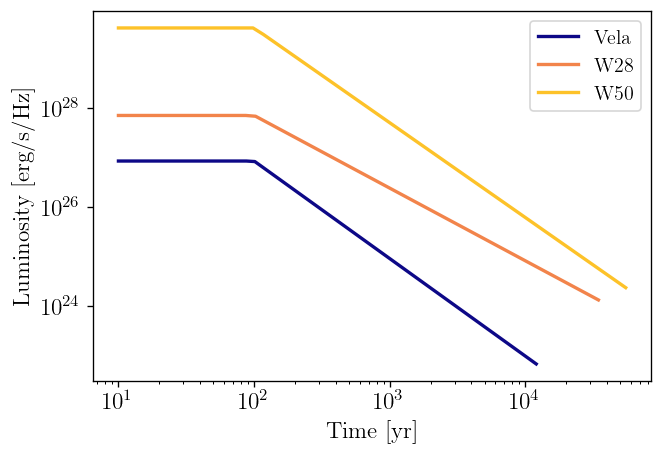

In [13]:
# plot Vela, W28 W50
fig, ax = plt.subplots()

colors = [ plt.get_cmap('plasma')(x) for x in [0.0, 0.7, 0.87] ]

for i, name in enumerate(['Vela', 'W28', 'W50']):
    snr = get_snr(name, snr_list_fullinfo)
    t_s = np.logspace(np.log10(10), np.log10(snr.t_now), 50) # [yr]
    L_s = [4*np.pi * (snr.d*kpc)**2 * 1e-23 * snr.Snu_t_fl(1000, t) for t in t_s]
    ax.plot(t_s, L_s, label=name, color=colors[i], lw=2)
ax.set(xscale='log', yscale='log')
ax.set(xlabel='Time [yr]', ylabel='Luminosity [erg/s/Hz]')
ax.legend();

In [14]:
# expected gegenschein flux
get_snr('Vela', snr_list_fullinfo).Sgnu(1000)

5.211844228977227e-05